<h1><center> PPOL564 - Data Science I: Foundations </center><h1>
<h3><center> Lecture 10 <br><br><font color='grey'> 
Data Exploration  <br> </font></center></h3>

## Concepts Covered Today:

- Initial Exploration of a Dataset
- Basics of Visualization
- Approaches to Data Exploration 
    - Numeric/Categorical 
    - univariate/bivariate 

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import scipy.stats as stats # for calculating the quantiles for a QQ plot
import requests

# Print all columns from the Pandas DataFrame
pd.set_option('display.max_columns', None) 

# Ignore warnings from Seaborn (specifically, future update warnings)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def download_data(git_loc,dest_name):
    '''
    Download data from Github and save to the notebook's working directory.
    '''
    req = requests.get(git_loc)
    with open(dest_name,"w") as file:
        for line in req.text:
            file.writelines(line)
            
download_data('https://raw.githubusercontent.com/edunford/ppol564/master/lectures/lecture_10/country_data.csv',
              "country_data.csv")

In [2]:
# Read in Data 
dat = pd.read_csv("country_data.csv")

# Data Exploration

### Dimensions

In [3]:
dat.shape

(13855, 12)

In [4]:
dat.columns

Index(['country', 'ccode', 'year', 'polity', 'gdppc', 'pop', 'continent',
       'regime_type', 'infant_mort', 'life_exp', 'life_exp_female',
       'life_exp_male'],
      dtype='object')

In [5]:
dat.index

RangeIndex(start=0, stop=13855, step=1)

### Determine the unit of observation

In [6]:
dat.head()

country  ccode    year  polity       gdppc           pop continent  \
0  Afghanistan    700  1800.0    -6.0  211.276682  1.564573e+07      Asia   
1  Afghanistan    700  1801.0    -6.0  211.276682  1.564573e+07      Asia   
2  Afghanistan    700  1802.0    -6.0  211.276682  1.564573e+07      Asia   
3  Afghanistan    700  1803.0    -6.0  211.276682  1.564573e+07      Asia   
4  Afghanistan    700  1804.0    -6.0  211.276682  1.564573e+07      Asia   

     regime_type  infant_mort  life_exp  life_exp_female  life_exp_male  
0  authoritarian          NaN       NaN              NaN            NaN  
1  authoritarian          NaN       NaN              NaN            NaN  
2  authoritarian          NaN       NaN              NaN            NaN  
3  authoritarian          NaN       NaN              NaN            NaN  
4  authoritarian          NaN       NaN              NaN            NaN

### Explore the data types

- What are the data types in the data? 
- Are they correct? 

In [7]:
dat.dtypes

country             object
ccode                int64
year               float64
polity             float64
gdppc              float64
pop                float64
continent           object
regime_type         object
infant_mort        float64
life_exp           float64
life_exp_female    float64
life_exp_male      float64
dtype: object

#### Clean:
- `year` to integer type
- `continent` to categorical type
- `regime_type` to categorical type

In [8]:
dat.year = dat.year.astype("int")
dat.country = dat.country.astype("category")
dat.continent = dat.continent.astype("category")
dat.regime_type = dat.regime_type.astype("category")

In [9]:
dat.dtypes

country            category
ccode                 int64
year                  int64
polity              float64
gdppc               float64
pop                 float64
continent          category
regime_type        category
infant_mort         float64
life_exp            float64
life_exp_female     float64
life_exp_male       float64
dtype: object

Categorical variables are similar to factor variables in `R`

In [10]:
dat.continent.unique()

[Asia, Europe, Africa, Americas, Oceania]
Categories (5, object): [Asia, Europe, Africa, Americas, Oceania]

In [11]:
dat.continent.cat.codes.unique()

array([2, 3, 0, 1, 4])

### Coverage

Depending on the unit of analysis:
- what's the temporal coverage of the data?
- what's the spatial coverage of the data?

In [12]:
min_year = dat.year.min()
max_year = dat.year.max()
print(f"The data ranges from {min_year} to {max_year}.")

The data ranges from 1800 to 2016.


In [13]:
dat.country.unique()

[Afghanistan, Albania, Algeria, Angola, Argentina, ..., Uruguay, United States, Venezuela, Zambia, Zimbabwe]
Length: 122
Categories (122, object): [Afghanistan, Albania, Algeria, Angola, ..., United States, Venezuela, Zambia, Zimbabwe]

_There are 122 countries in the data._

Are all countries in the data for the same years? A simple way we can explore this is to plot the spatial unit (if fixed and not too large, on the temporal unit.

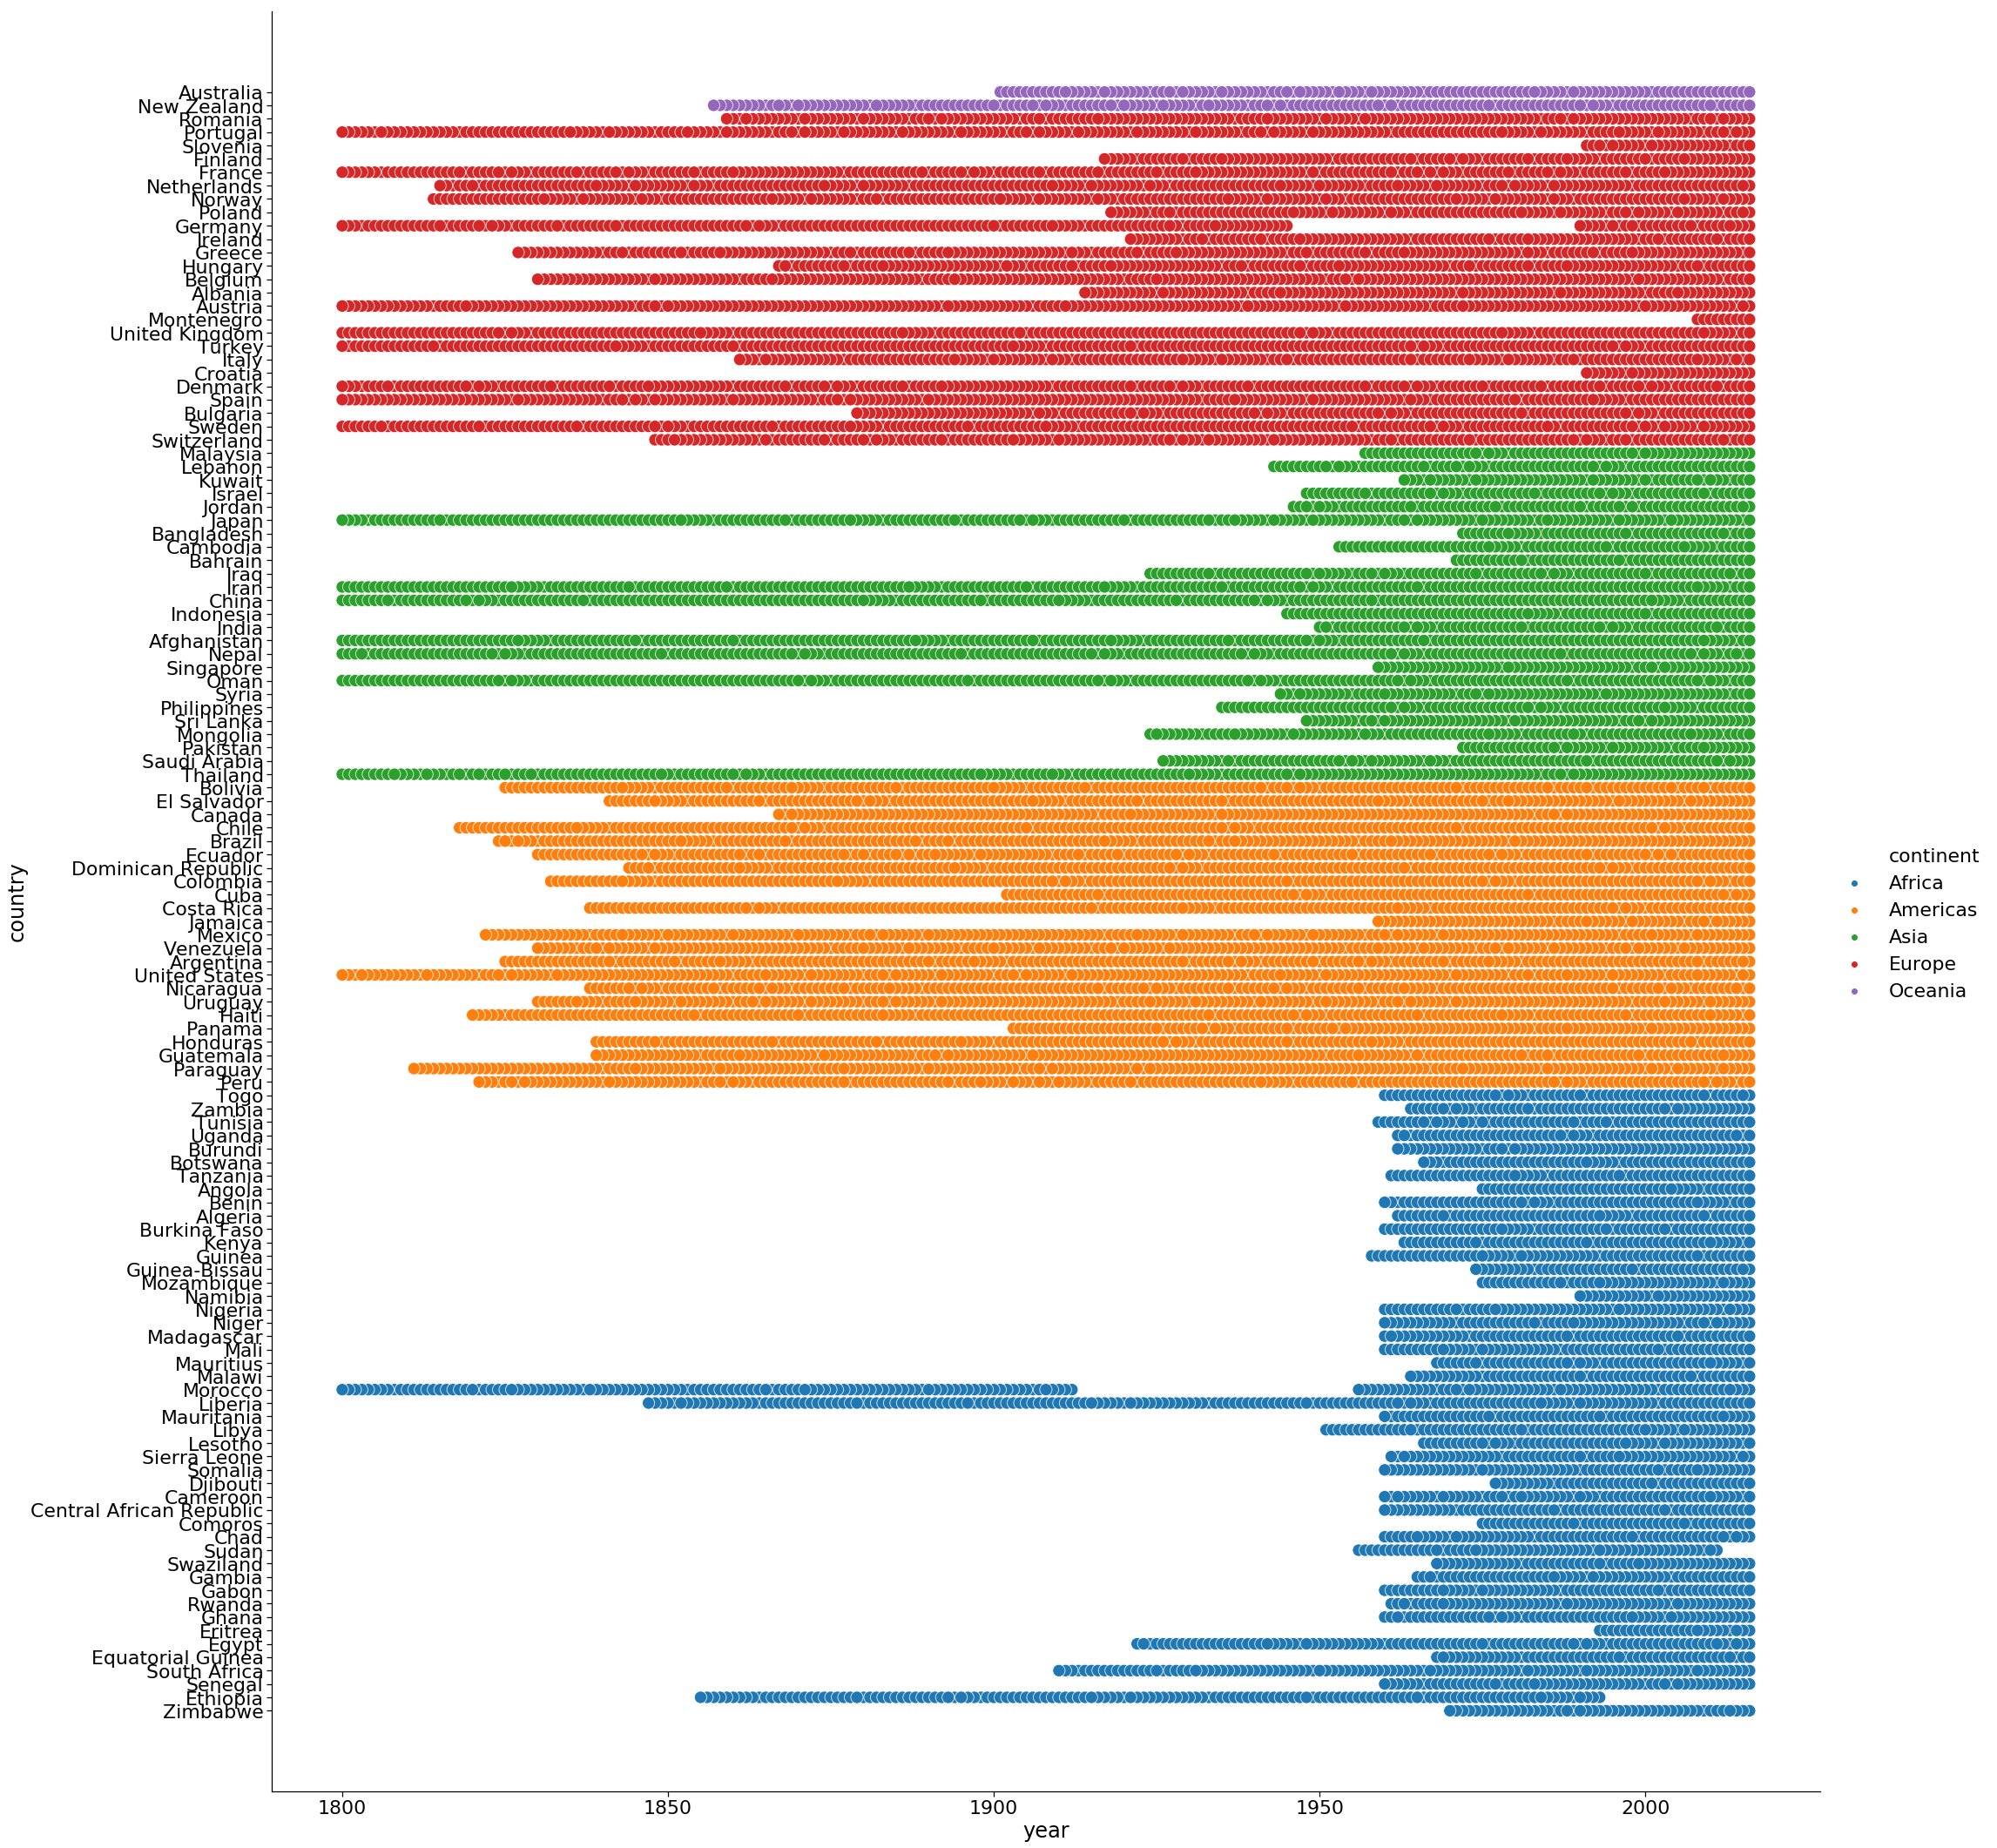

In [22]:
sns.set_context("notebook", font_scale=2)
g = sns.relplot("year","country",
                hue = "continent",
                kind="scatter",
                height=30,s=200,
                data=dat.sort_values('continent'))

As we can see there are large inconsistencies in coverage. Only a few countries are in the data for the whole 1800 to 2016 time period. Others drop in and out (potentially given their political status). We need to proceed cautiously when using this data in its raw format.

### Missingness
- Is there any missing data?
- If so, why is it missing?
- Should the missing values be dropped/imputed/left alone?

In [15]:
# Count the missing entries
dat.isna().sum(axis=0)

country               0
ccode                 0
year                  0
polity                0
gdppc                 0
pop                   0
continent             0
regime_type           0
infant_mort        7638
life_exp           7370
life_exp_female    7370
life_exp_male      7370
dtype: int64

In [16]:
# Proportion of missingness
(dat.isna().sum(axis=0)/dat.shape[0]).round(2)

country            0.00
ccode              0.00
year               0.00
polity             0.00
gdppc              0.00
pop                0.00
continent          0.00
regime_type        0.00
infant_mort        0.55
life_exp           0.53
life_exp_female    0.53
life_exp_male      0.53
dtype: float64

Roughly half the data is missing for four of the `float` indicators in the data. 

- Are these entries missing at random?
- Are they missing for certain units of observation?
    - e.g. for specific year ranges or for specific countries?
- What is the best strategy to deal with them?

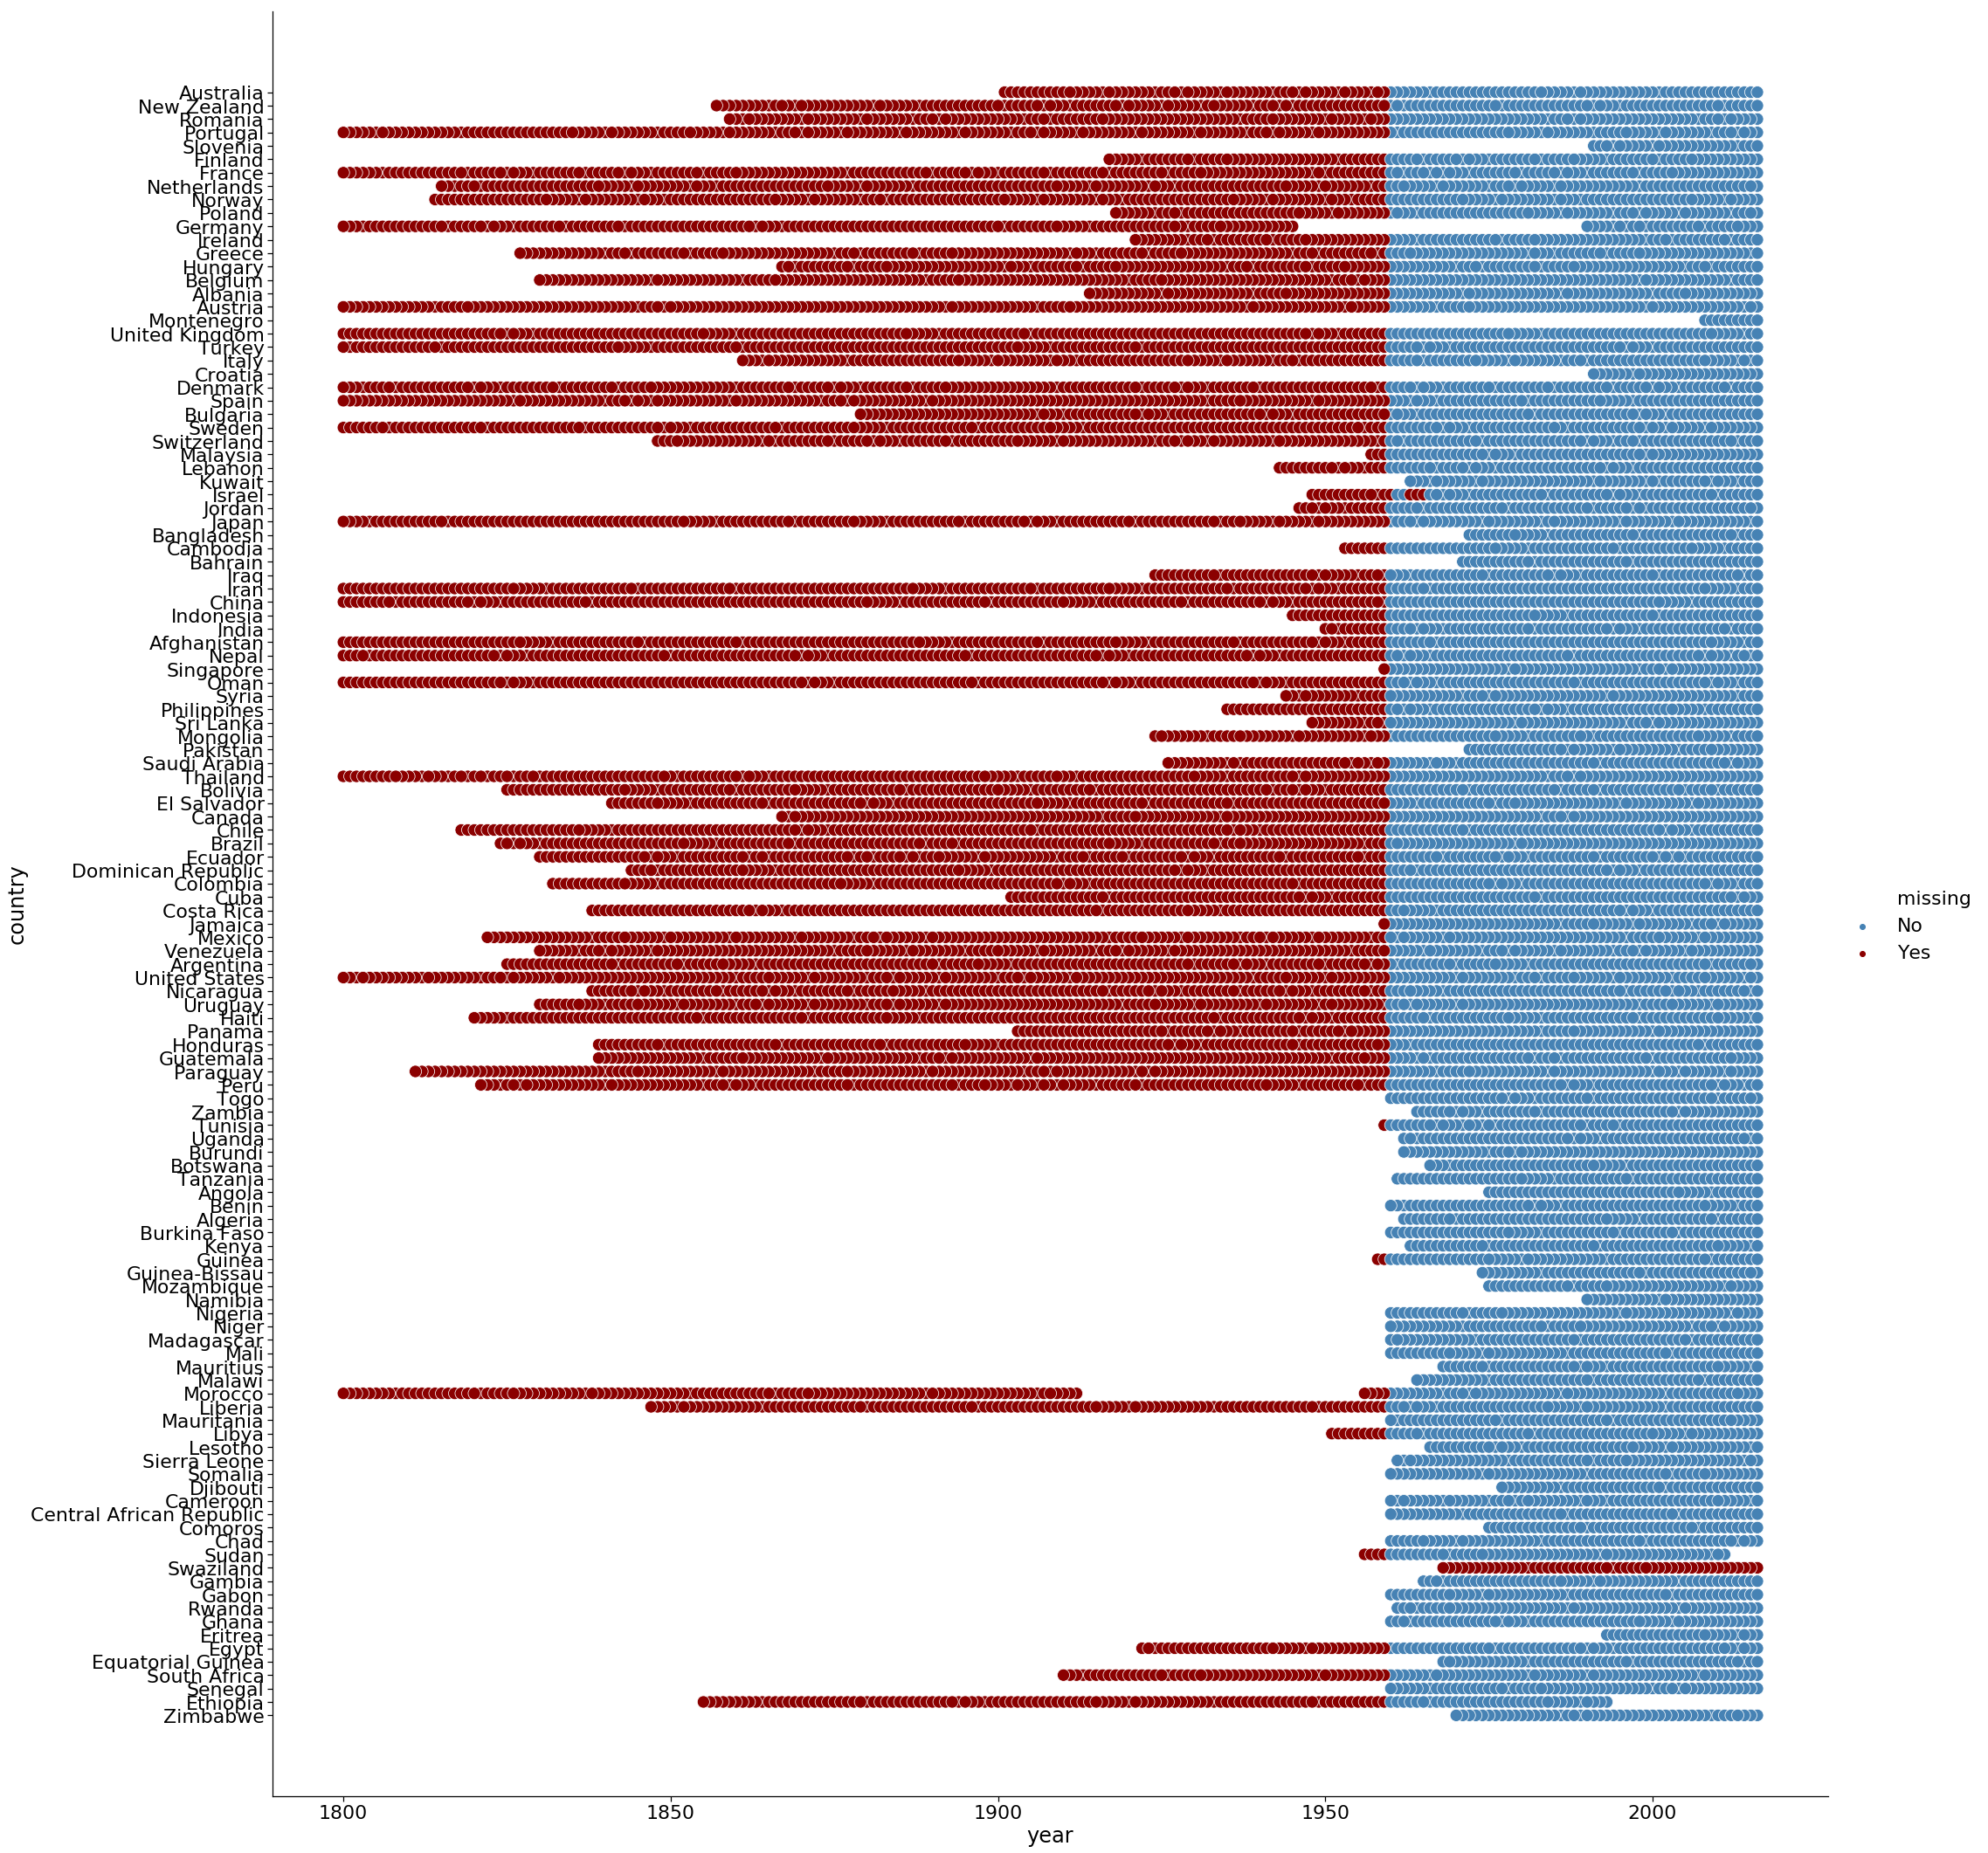

In [17]:
dat = dat.assign(missing = np.where(dat.life_exp.isna(),"Yes","No"))
sns.relplot("year","country",
            hue='missing',
            kind="scatter",
            height=30,s=200,
            palette = ["steelblue","darkred"],
            data=dat.sort_values('continent'))

It looks like the life expectancy indicators only cover from 1960 onward. To use these data, we can only consider this time period. Thus, a feasible strategy to deal with the missingness might be to **_reduce the scope of our analysis to only include 1960 through 2016_**.

In [23]:
dat = dat.query("year >= 1960").reset_index()
dat.shape

(6538, 14)

### Features of Interest

- Determined by:
    - Research question
    - Research design
    - Data availability
    
    
- **What is the outcome of interest?**
    - Economic Growth (GDP Per Capita)
    - Population Growth
    - Standard of Living (Life expectancy and/or infant mortality)
    
    
- **What is are the key predictors (independent variables/features)?**
    - Theory about the data generating process (DGP)
    - Features found to be predictive from prior research
    - Variable selection model to determine feature importance.

# Basics of Visualization

### What do you see?
<br>
<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/lecture-week-05_data-visualization_files/figure-html/unnamed-chunk-1-1.png" width="80%"/>
</div>

### Aesthetics 

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/common-aesthetics-1.png" width="50%"/>
</div>

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/basic-scales-example-1.png" width="50%"/>
</div>



### Using Color


### <center> Color as a tool to distinguish </center>
<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/breakdown-by-year_25km-1day-window.png" width="60%"/>
</div>

<br>

### <center> Color as a tool to represent values </center>
<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/violent-events-2016_by-adm-unit_by-dataset.png" width="60%"/>
</div>

<br>

### <center> Color as a tool to highlight </center>
<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/lecture-week-05_data-visualization_files/figure-html/unnamed-chunk-2-1.png" width="60%"/>
</div>

### Presentation as Distortion

<br>
<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/lecture-week-05_data-visualization_files/figure-html/unnamed-chunk-5-1.png" width="60%"/>
</div>

<br>

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/lecture-week-05_data-visualization_files/figure-html/unnamed-chunk-6-1.png" width="60%"/>
</div>




## Data types drives visualization decisions

|Data Type |	Example	| Scale |
|:-------:|:-------:|:-----:|
Numerical |	1.3, 800, 10e3 |	Continuous
Integer	| 1, 2, 3|	Discrete (when $n$ is small), Continuous (when $n$ is large)
Categorical|	"dog", "Nigeria", "A"|	Discrete
Ordered	|"Small", "Medium", "Large"|	Discrete
Dates/Time |	2009-01-02, 5:32:33 |	Continuous

<br>


### <center> Discrete Values </center>

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/amounts-1.png" width="60%"/>
    <img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/proportions-1.png" width="60%"/>
</div>


### <center> Continuous Values </center>

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/single-distributions-1.png" width="60%"/>
</div>


### <center> Relationships </center>

<div>
<img src="http://ericdunford.com/ppol670/Lectures/week_05/Figures/basic-scatter-1.png" width="60%"/>
</div>



# Exploring Univariate Distributions

## Numerical Summaries

### Continuous Variables

- **Five Number Summary:**
    - Minimum Value
    - First Quartile (25%)
    - Median (50%)
    - Third Quartile (75%)
    - Maximum Value
    
    
- **Moments of the Distribution:**
    - Mean (central tendency)
    - Standard Deviation (Spread)
    
    
Pandas offers both these summaries jointly with the the `.describe()` method.

In [24]:
dat.describe(include="float").round(1).T

count        mean          std       min        25%  \
polity           6538.0         1.1          7.4     -10.0       -7.0   
gdppc            6538.0      5814.4      11299.3      37.5      383.1   
pop              6538.0  38776599.2  133833028.0  220312.0  3723898.8   
infant_mort      6217.0        58.0         48.7       1.6       15.7   
life_exp         6485.0        62.7         12.2      18.9       52.9   
life_exp_female  6485.0        64.9         12.8      22.4       54.4   
life_exp_male    6485.0        60.6         11.7      16.3       51.2   

                       50%         75%           max  
polity                 2.0         9.0  1.000000e+01  
gdppc               1210.6      5147.7  1.030592e+05  
pop              8930337.0  23616013.7  1.378665e+09  
infant_mort           45.6        92.5  2.365000e+02  
life_exp              65.0        72.9  8.400000e+01  
life_exp_female       67.2        75.7  8.710000e+01  
life_exp_male         62.9        70.2  8.170000e+01

### Categorical (Discrete) Variables

In [33]:
dat.describe(include="category").T

count unique        top  freq
country      6538    122     Jordan    57
continent    6538      5     Africa  2441
regime_type  6538      3  democracy  2803

In [34]:
dat.groupby(['continent']).size()

continent
Africa      2441
Americas    1311
Asia        1387
Europe      1285
Oceania      114
dtype: int64

In [39]:
dat.groupby(['country']).size().sort_values(ascending=False).head()

country
Jordan       57
Indonesia    57
France       57
Gabon        57
Ghana        57
dtype: int64

In [41]:
dat.groupby(['regime_type']).size().sort_values(ascending=False).head()

regime_type
democracy                    2803
authoritarian                2227
competitive authoritarian    1508
dtype: int64

## Visual Summaries

### Continuous Variables

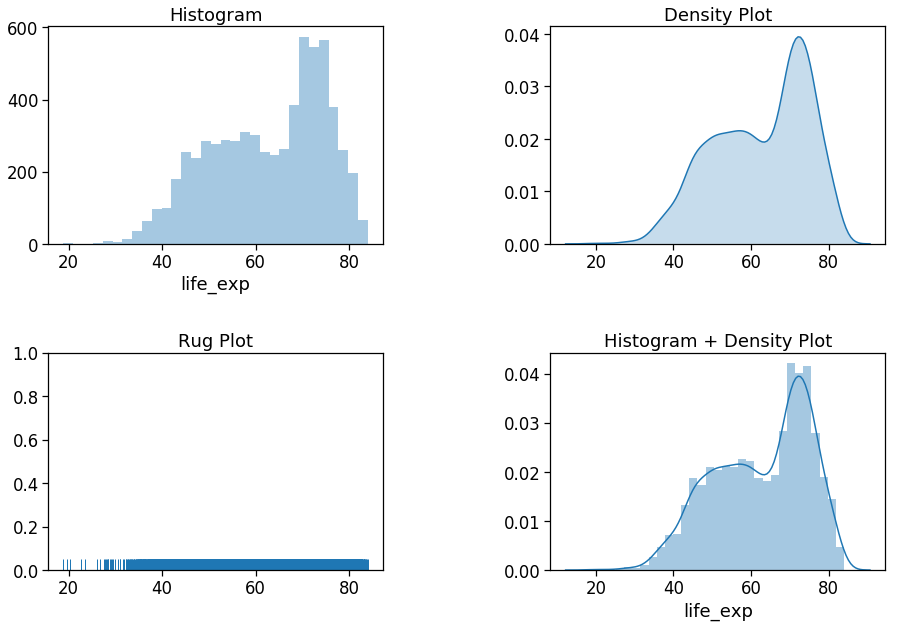

In [93]:
# Rest the basic setup
sns.set_context("notebook", font_scale=1.5)

# Set up a subplot using matplotlib
f, axes = plt.subplots(2, 2, figsize=(15, 10))  # set up the 
plt.subplots_adjust(wspace = 0.5,hspace = 0.5) # increase the space between plots

# assign a variable
var = dat["life_exp"].dropna()

g = sns.distplot(var,hist=True,kde=False,ax=axes[0,0])
g.set_title("Histogram")

g = sns.kdeplot(var,shade=True,ax=axes[0,1],legend=False)
g.set_title("Density Plot")

g = sns.rugplot(var,ax=axes[1,0])
g.set_title("Rug Plot")

g = sns.distplot(var,hist=True,kde=True,ax=axes[1,1])
g.set_title("Histogram + Density Plot")

plt.show()

#### Q-Q Plots (quantile-quantile plots) 
Compares the empirical distribution to the theoretical distribution. In practice, how normally distributed is our empirical variable.

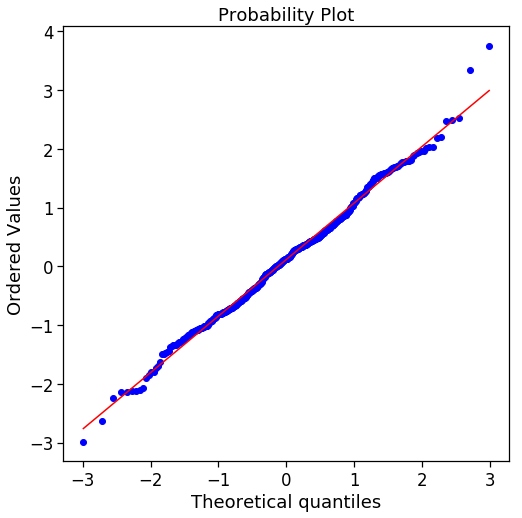

In [142]:
# With a tehoretically perfectly distributed variable
plt.figure(figsize=(8,8))
x = np.random.normal(0,1,500)
_ = stats.probplot(x, dist="norm",plot=plt)

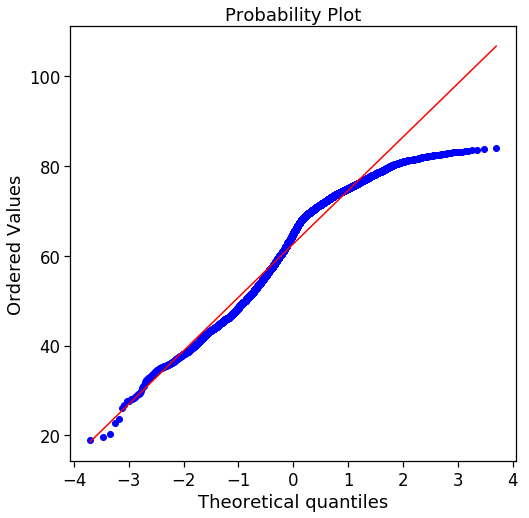

In [143]:
# With our actual life expectancy variable 
plt.figure(figsize=(8,8))
_ = stats.probplot(var, dist="norm",plot=plt)

#### Histograms

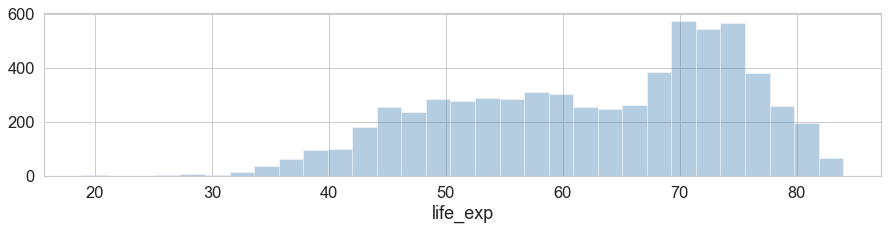

In [423]:
plt.figure(figsize=(15,3))
g = sns.distplot(dat["life_exp"].dropna(),
                 color="steelblue",
                 hist=True,kde=False)

For Histograms, bin size can yield a disparate pictures of a variable.

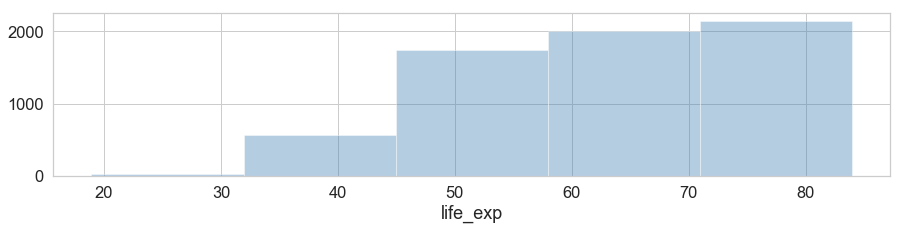

In [424]:
plt.figure(figsize=(15,3))
g = sns.distplot(dat["life_exp"].dropna(),
                 color="steelblue",
                 bins=5,
                 hist=True,kde=False)

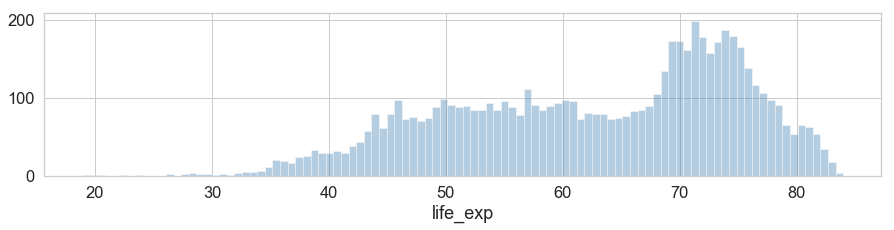

In [425]:
plt.figure(figsize=(15,3))
g = sns.distplot(dat["life_exp"].dropna(),
                 color="steelblue",
                 bins=100,
                 hist=True,kde=False)

Using a combination of the matplotlib and seaborn libraries, we can easily generate subgraphs to plot many variables simultaneously.

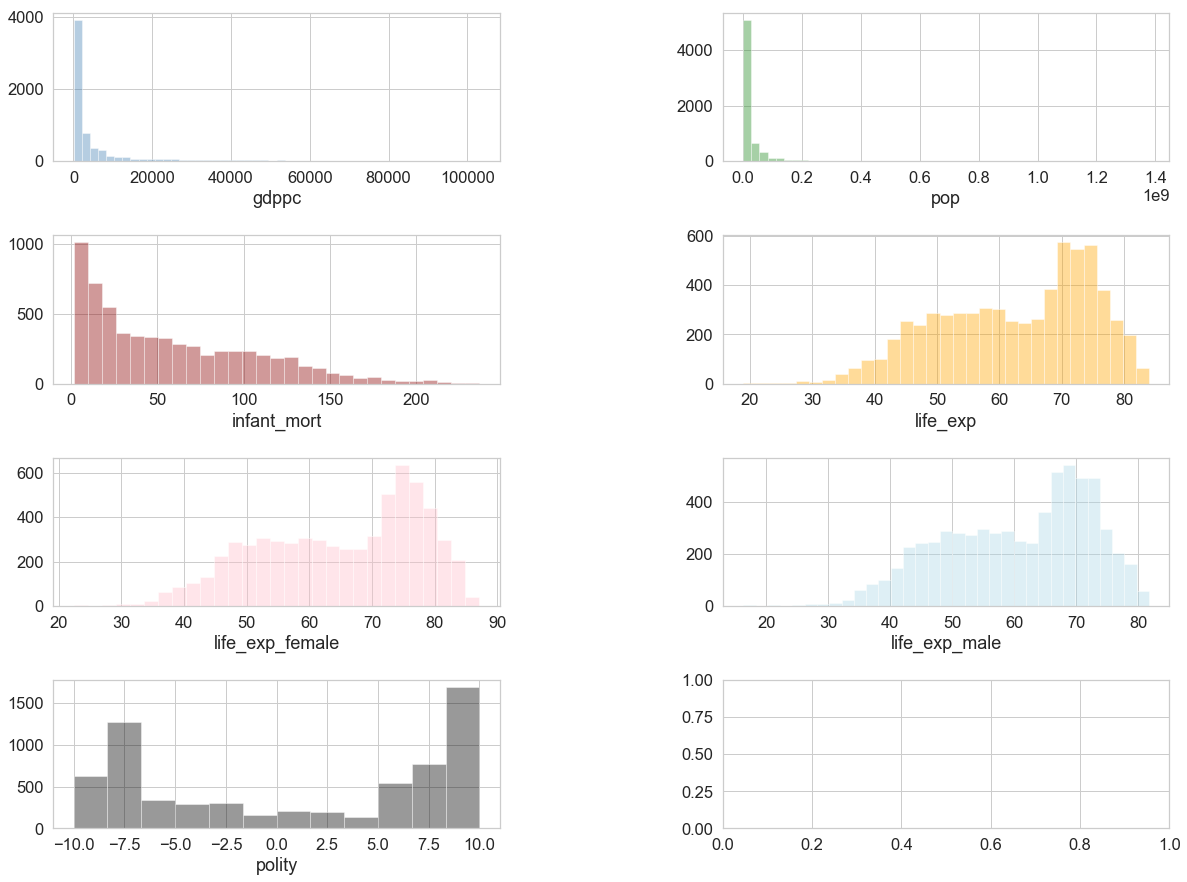

In [426]:
f, axes = plt.subplots(4, 2, figsize=(20, 15))
plt.subplots_adjust(wspace = 0.5,hspace = 0.5) 

sns.distplot(dat["gdppc"],
             color="steelblue",
             hist=True,kde=False,ax=axes[0,0])

sns.distplot(dat["pop"],
             color="forestgreen",
             hist=True,kde=False,ax=axes[0,1])

sns.distplot(dat["infant_mort"].dropna(),
             color="darkred",
             hist=True,kde=False,ax=axes[1,0])

sns.distplot(dat["life_exp"].dropna(),
             color="orange",
             hist=True,kde=False,ax=axes[1,1])

sns.distplot(dat["life_exp_female"].dropna(),
             color="pink",
             hist=True,kde=False,ax=axes[2,0])

sns.distplot(dat["life_exp_male"].dropna(),
             color="lightblue",
             hist=True,kde=False,ax=axes[2,1])

sns.distplot(dat["polity"].dropna(),
             color="black",
             hist=True,kde=False,ax=axes[3,0])
plt.show()

### Scaling Continuous Variables  

One thing that should instantly stand out is that the **_scales_** differ widely.

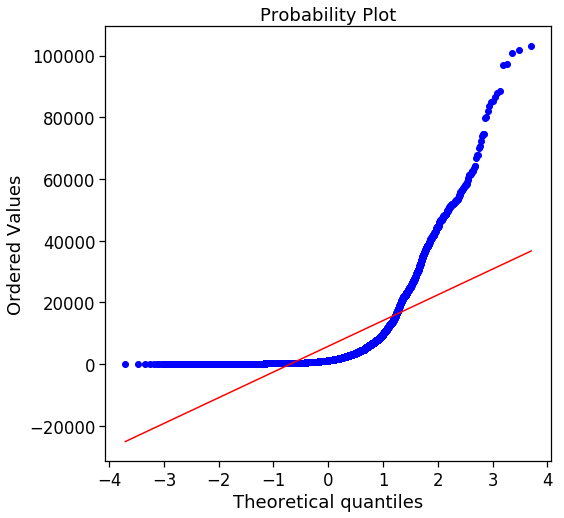

In [144]:
# Looking at the QQ plot, we can see the variable is way off from being normally distributed. 
plt.figure(figsize=(8,8))  
d, x = stats.probplot(dat["gdppc"], dist="norm",plot=plt)

#### Log transformation 

We can adjust the right skewed data with large tail values by taking the **_natural log_** of the variable. 

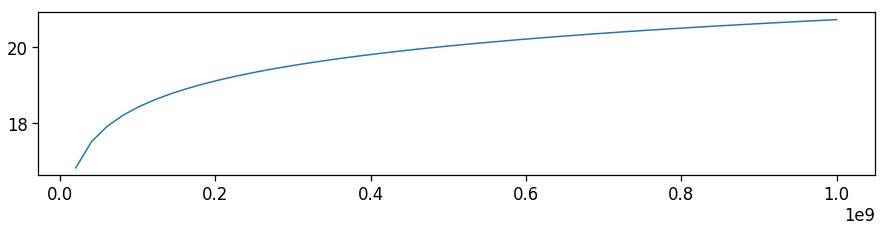

In [121]:
# Demonstrate what a log transformation does.
x = np.linspace(0,10e8)
y = np.log(x)

plt.figure(figsize=(15,3))
g = sns.lineplot(x,y)

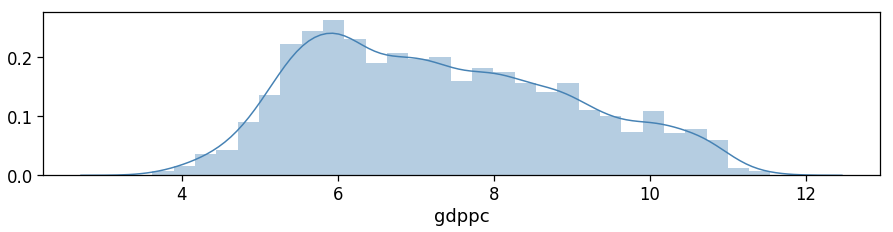

In [146]:
plt.figure(figsize=(15,3))
x = np.log(dat["gdppc"])
g = sns.distplot(x,
                 color="steelblue",
                 hist=True,kde=True)

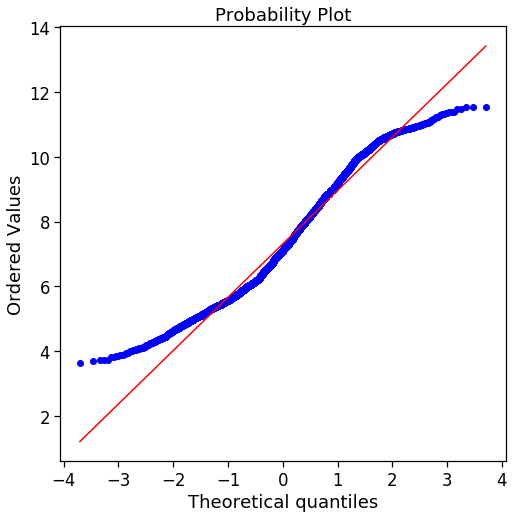

In [145]:
# From the QQ plot, we can see the variable appears more normally distributed once transformed. 
plt.figure(figsize=(8,8))  
d, x = stats.probplot(np.log(dat["gdppc"]), dist="norm",plot=plt)

Let's create two new variables that takes the natural log of GDP per capita and Population.

In [167]:
dat['lngdppc'] = np.log(dat['gdppc']) 
dat['lnpop'] = np.log(dat['pop'])
dat.head(3)

index      country  ccode  year  polity      gdppc        pop continent  \
0    160  Afghanistan    700  1960   -10.0  59.777327  8996351.0      Asia   
1    161  Afghanistan    700  1961   -10.0  59.878153  9166764.0      Asia   
2    162  Afghanistan    700  1962   -10.0  58.492874  9345868.0      Asia   

     regime_type  infant_mort  life_exp  life_exp_female  life_exp_male  \
0  authoritarian          NaN    32.446           33.314         31.718   
1  authoritarian        236.5    32.962           33.840         32.224   
2  authoritarian        232.6    33.471           34.359         32.724   

  missing   lngdppc      lnpop  
0      No  4.090626  16.012330  
1      No  4.092312  16.031095  
2      No  4.068905  16.050445

#### Standardizing

Standardizes the distribution of the variable by setting the mean to 0 and the variance to 1. This transformation retains the original form of the empirical distribution. 

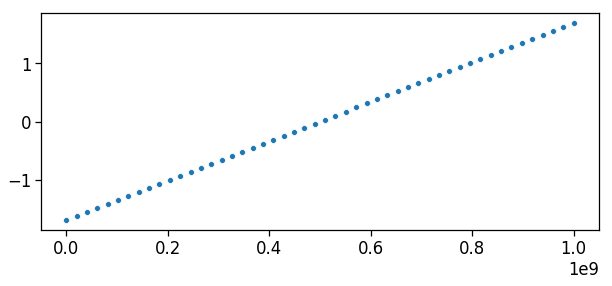

In [173]:
def standardize(x): 
    return (x - x.mean())/x.std()


# Sim Numbers
x = np.linspace(0,10e8)
y = standardize(x)


plt.figure(figsize=(10,4))
sns.scatterplot(x,y)

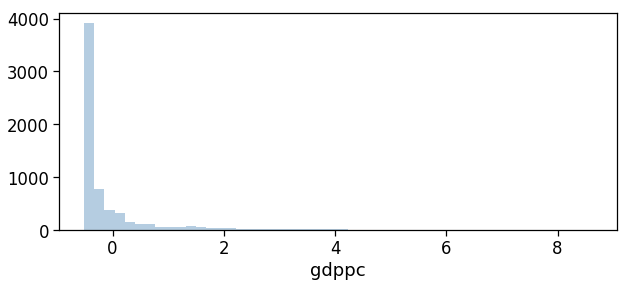

In [123]:
plt.figure(figsize=(10,4))
x = standardize(dat["gdppc"])
g = sns.distplot(x,
                 color="steelblue",
                 hist=True,kde=False)

#### Scale by Empirical Range

Scales values so that they exist between 0 and 1, where 0 corresponds with the minimum value, and 1 corresponds with the maximum value. This transformation retains the original form of the empirical distribution. 

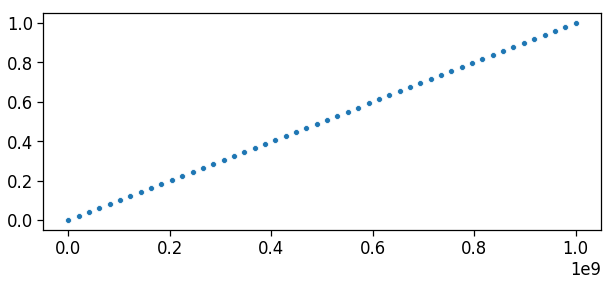

In [172]:
def range_scale(x): 
    return (x - x.min())/(x.max()-x.min())

# Sim Numbers
x = np.linspace(0,10e8)
y = range_scale(x)

plt.figure(figsize=(10,4))
sns.scatterplot(x,y)

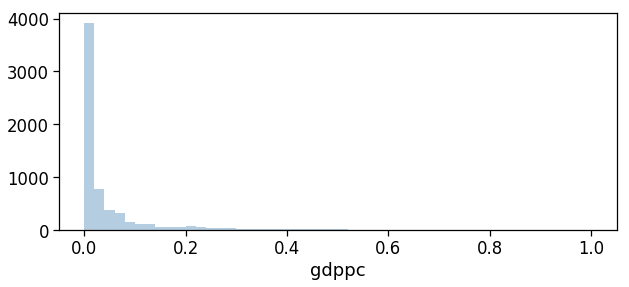

In [125]:
plt.figure(figsize=(10,4))
x = range_scale(dat["gdppc"])
g = sns.distplot(x,
                 color="steelblue",
                 hist=True,kde=False)

### Categorical (Discrete) Variables

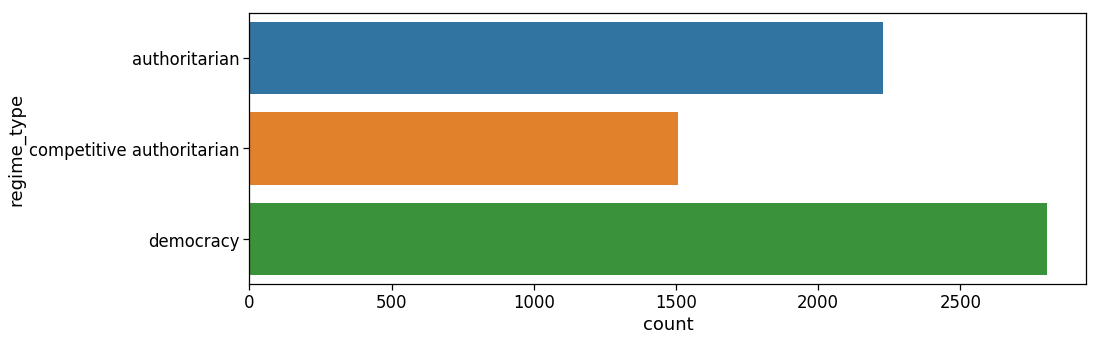

In [152]:
plt.figure(figsize=(15,5))
g = sns.countplot(y="regime_type", data=dat)

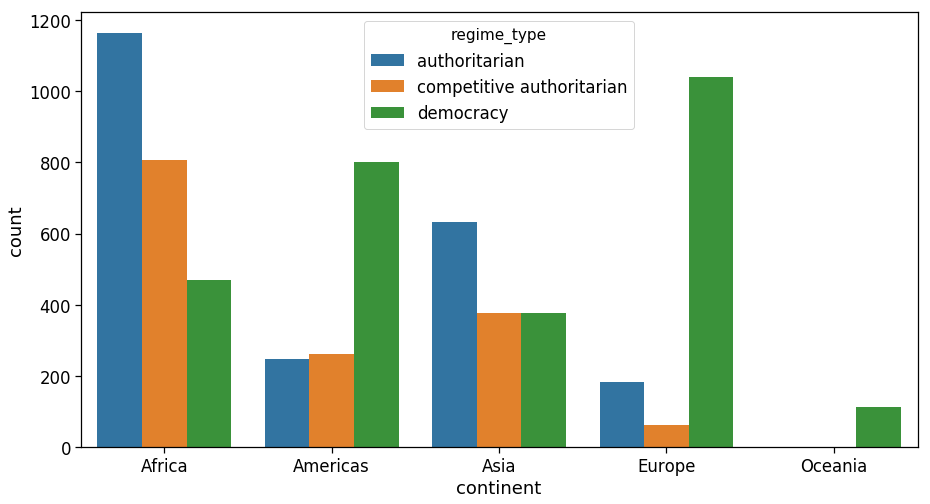

In [133]:
plt.figure(figsize=(15,8))
g = sns.countplot(x="continent",hue="regime_type", data=dat)

# Exploring Bivariate Distributions

## Numerical Summaries

### Continuous Variables

#### Correlation

Explore the linear relationship between two (or more) variables.

$$r_{xy} = \frac{\sum^i_N  (x_i - \bar{x}) (y_i - \bar{y}) }{ \sqrt{\sum^i_N  (x_i - \bar{x})^2 (y_i - \bar{y})^2  } }$$

In [168]:
dat['life_exp'].corr(dat['lngdppc']).round(2)

0.83

#### Correlation Matrix

In [170]:
# Expand out to a correlation matrx
dat.loc[:,"polity":"lnpop"].corr().round(2)

polity  gdppc   pop  infant_mort  life_exp  life_exp_female  \
polity             1.00   0.36  0.03        -0.55      0.53             0.55   
gdppc              0.36   1.00 -0.01        -0.48      0.55             0.54   
pop                0.03  -0.01  1.00        -0.04      0.07             0.06   
infant_mort       -0.55  -0.48 -0.04         1.00     -0.94            -0.95   
life_exp           0.53   0.55  0.07        -0.94      1.00             1.00   
life_exp_female    0.55   0.54  0.06        -0.95      1.00             1.00   
life_exp_male      0.52   0.56  0.08        -0.93      1.00             0.99   
lngdppc            0.46   0.75 -0.03        -0.80      0.83             0.83   
lnpop              0.18   0.08  0.58        -0.16      0.21             0.21   

                 life_exp_male  lngdppc  lnpop  
polity                    0.52     0.46   0.18  
gdppc                     0.56     0.75   0.08  
pop                       0.08    -0.03   0.58  
infant_mort              -0.93    -0.80  -0.16  
life_exp                  1.00     0.83   0.21  
life_exp_female           0.99     0.83   0.21  
life_exp_male             1.00     0.83   0.21  
lngdppc                   0.83     1.00   0.09  
lnpop                     0.21     0.09   1.00

### Categorical (Discrete) Variables

**Crosstabs**

In [60]:
pd.crosstab(dat.regime_type,dat.continent,margins=True)

continent                  Africa  Americas  Asia  Europe  Oceania   All
regime_type                                                             
authoritarian                1163       249   633     182        0  2227
competitive authoritarian     808       261   377      62        0  1508
democracy                     470       801   377    1041      114  2803
All                          2441      1311  1387    1285      114  6538

Cross tabs represented as **_proportions_**

In [66]:
# By Rows
pd.crosstab(dat.regime_type,dat.continent).apply(lambda x: x/x.sum(), axis=1).round(3)

continent                  Africa  Americas   Asia  Europe  Oceania
regime_type                                                        
authoritarian               0.522     0.112  0.284   0.082    0.000
competitive authoritarian   0.536     0.173  0.250   0.041    0.000
democracy                   0.168     0.286  0.134   0.371    0.041

In [67]:
# By Columns
pd.crosstab(dat.regime_type,dat.continent).apply(lambda x: x/x.sum(), axis=0).round(3)

continent                  Africa  Americas   Asia  Europe  Oceania
regime_type                                                        
authoritarian               0.476     0.190  0.456   0.142      0.0
competitive authoritarian   0.331     0.199  0.272   0.048      0.0
democracy                   0.193     0.611  0.272   0.810      1.0

### Categorical + Continuous 

In [180]:
dat.groupby(['continent'])['gdppc'].mean().sort_values(ascending=False)

continent
Oceania     17352.233249
Europe      16050.537032
Asia         5116.408798
Americas     4281.519876
Africa       1106.908969
Name: gdppc, dtype: float64

In [188]:
dat.groupby(['country'])['lnpop'].mean().sort_values(ascending=False).head(5).round(2)

country
China            20.77
India            20.51
United States    19.32
Indonesia        18.92
Brazil           18.73
Name: lnpop, dtype: float64

## Visual Summaries

### Continuous Variables

**scatter plot**

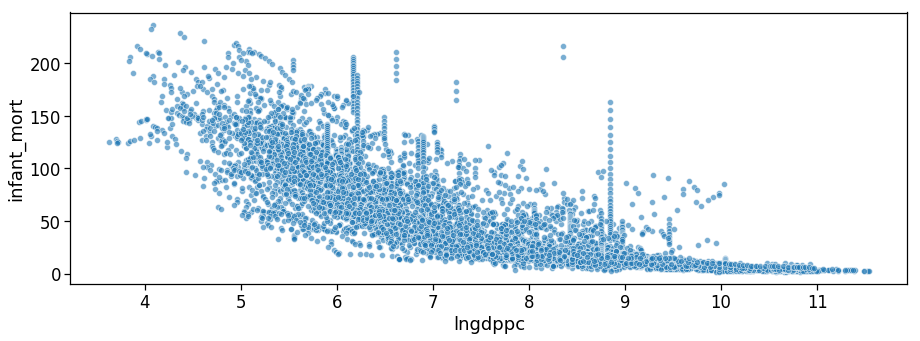

In [254]:
plt.figure(figsize=(15,5))
sns.scatterplot(x="lngdppc",y="infant_mort",alpha=.6,data=dat)

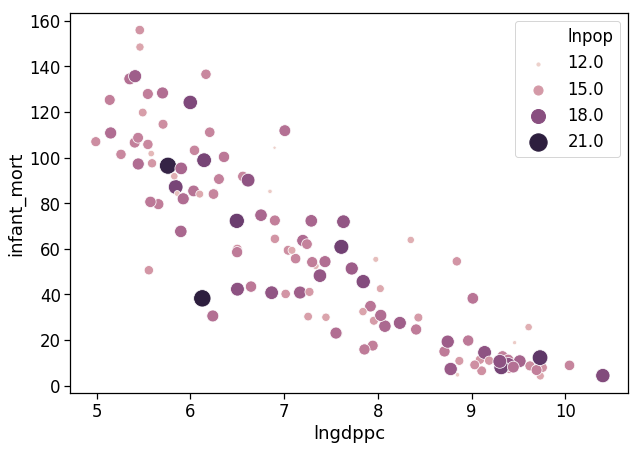

In [227]:
plt.figure(figsize=(10,7))

# Summarize data 
d = (dat
     .groupby(['country'])
     .mean()
     .reset_index())
 
# plot relationship
g = sns.scatterplot(x="lngdppc",
                    y="infant_mort",
                    size='lnpop',
                    hue = 'lnpop',
                    sizes=(10, 300),
                    data=d)

**Line plot**

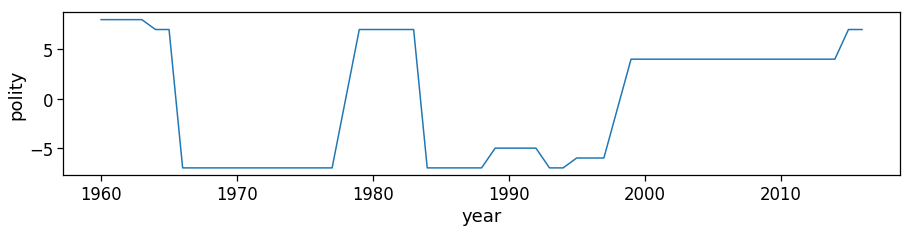

In [198]:
plt.figure(figsize=(15,3))
sns.lineplot(x="year",y="polity",data=dat.query("country == 'Nigeria'"))

#### Univariate and Bivariate Together 

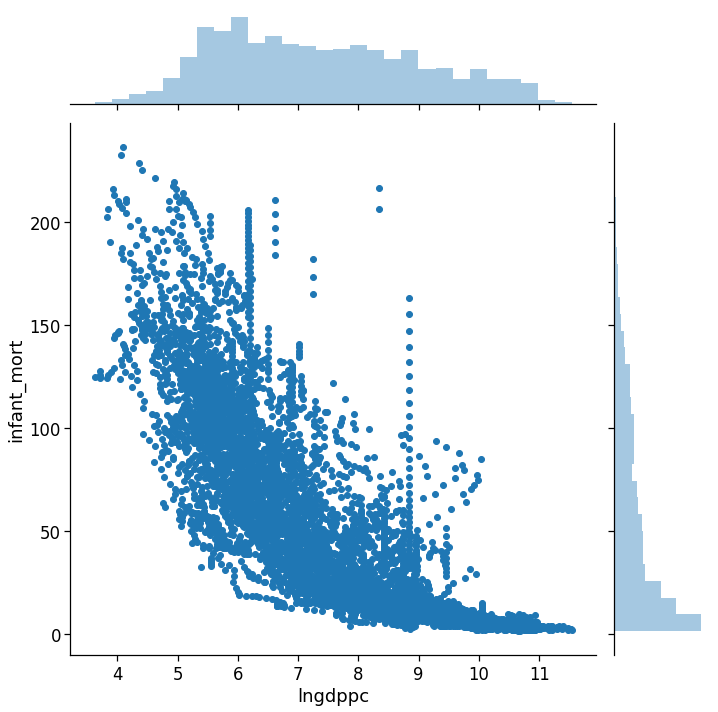

In [250]:
sns.jointplot(x="lngdppc",y="infant_mort",data=dat,
              height=10)

#### Fitting the relationship

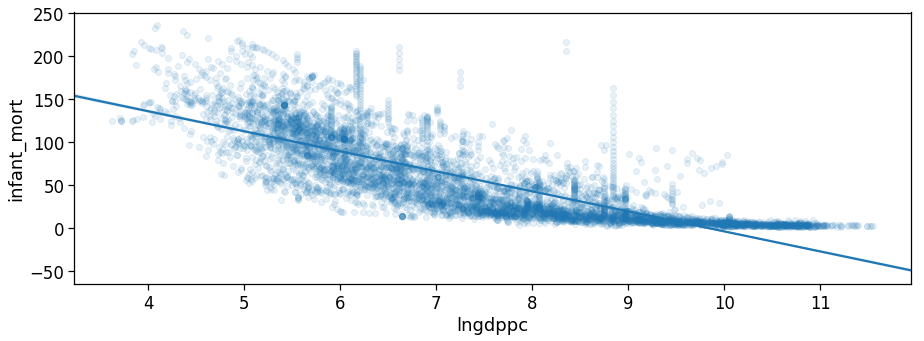

In [257]:
# Regression line 
plt.figure(figsize=(15,5))
g = sns.regplot(x="lngdppc",y="infant_mort",
                scatter_kws={'alpha':0.1},
                data=dat)

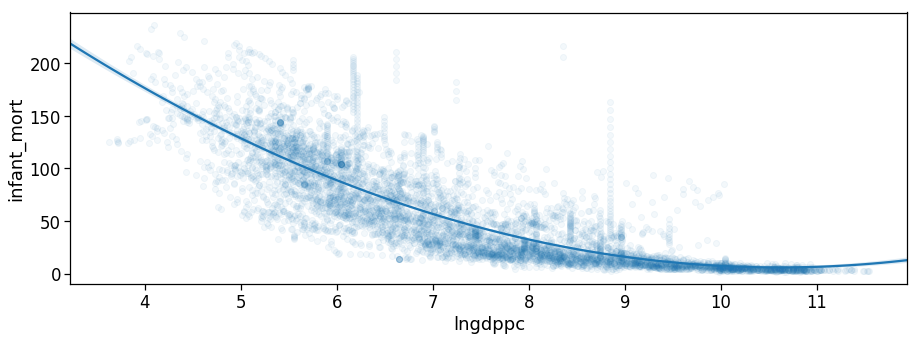

In [267]:
# Higher order regression line: x + x^2
plt.figure(figsize=(15,5))
g = sns.regplot(x="lngdppc",y="infant_mort",
                scatter_kws={'alpha':0.05},
                order=2,
                data=dat)

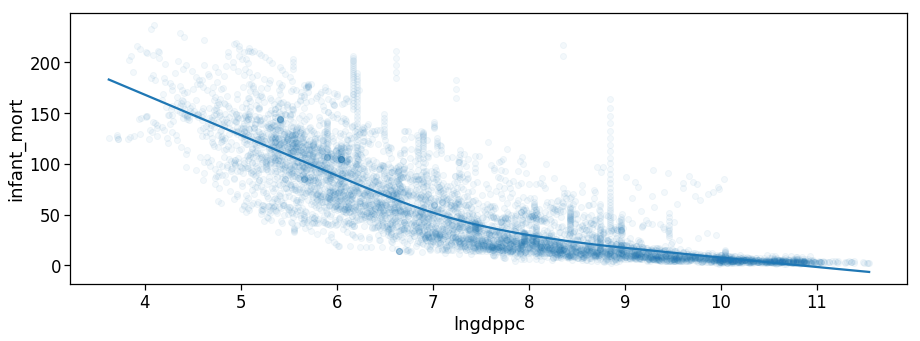

In [265]:
# Lowess (locally weighted linear) regression
plt.figure(figsize=(15,5))
g = sns.regplot(x="lngdppc",y="infant_mort",
                scatter_kws={'alpha':0.05},
                lowess=True,
                data=dat)

<Figure size 1080x360 with 0 Axes>

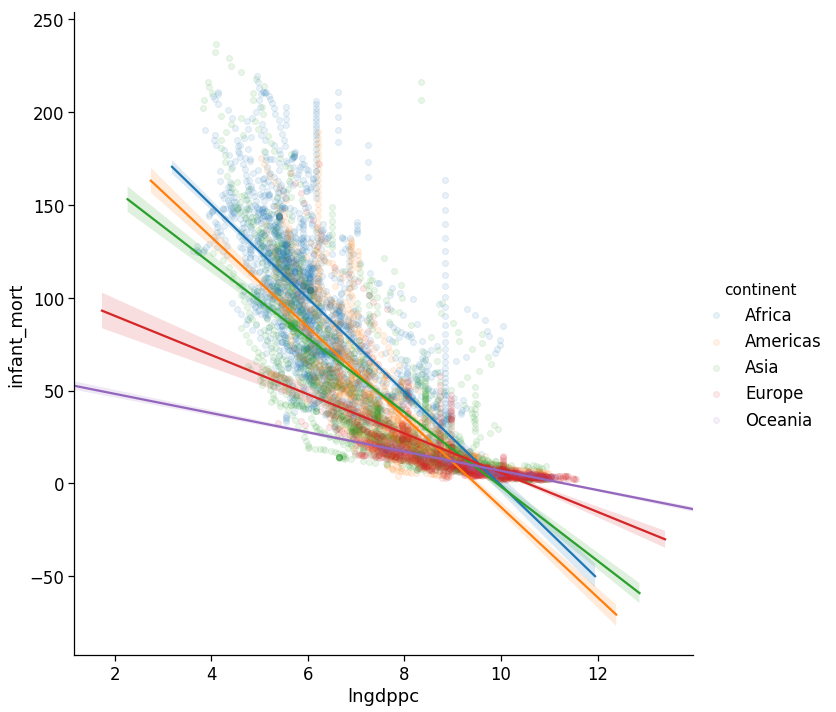

In [358]:
# Regression by Grouping 
plt.figure(figsize=(15,5))
g = sns.lmplot(x="lngdppc",y="infant_mort",
                hue="continent",
                scatter_kws={'alpha':0.1},
                height=10,
                data=dat)

#### Heatmaps

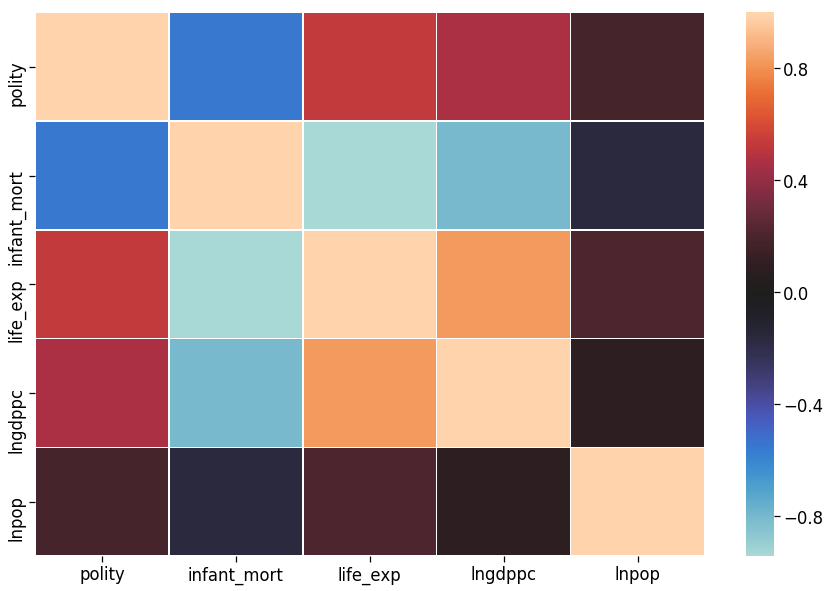

In [282]:
# Generate a correlation matrix 
corr_mat = dat.loc[:,["polity","infant_mort","life_exp","lngdppc","lnpop"] ].corr()

# Generate a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat,
            center=0,
            linewidths=.5)

#### Pair Plots

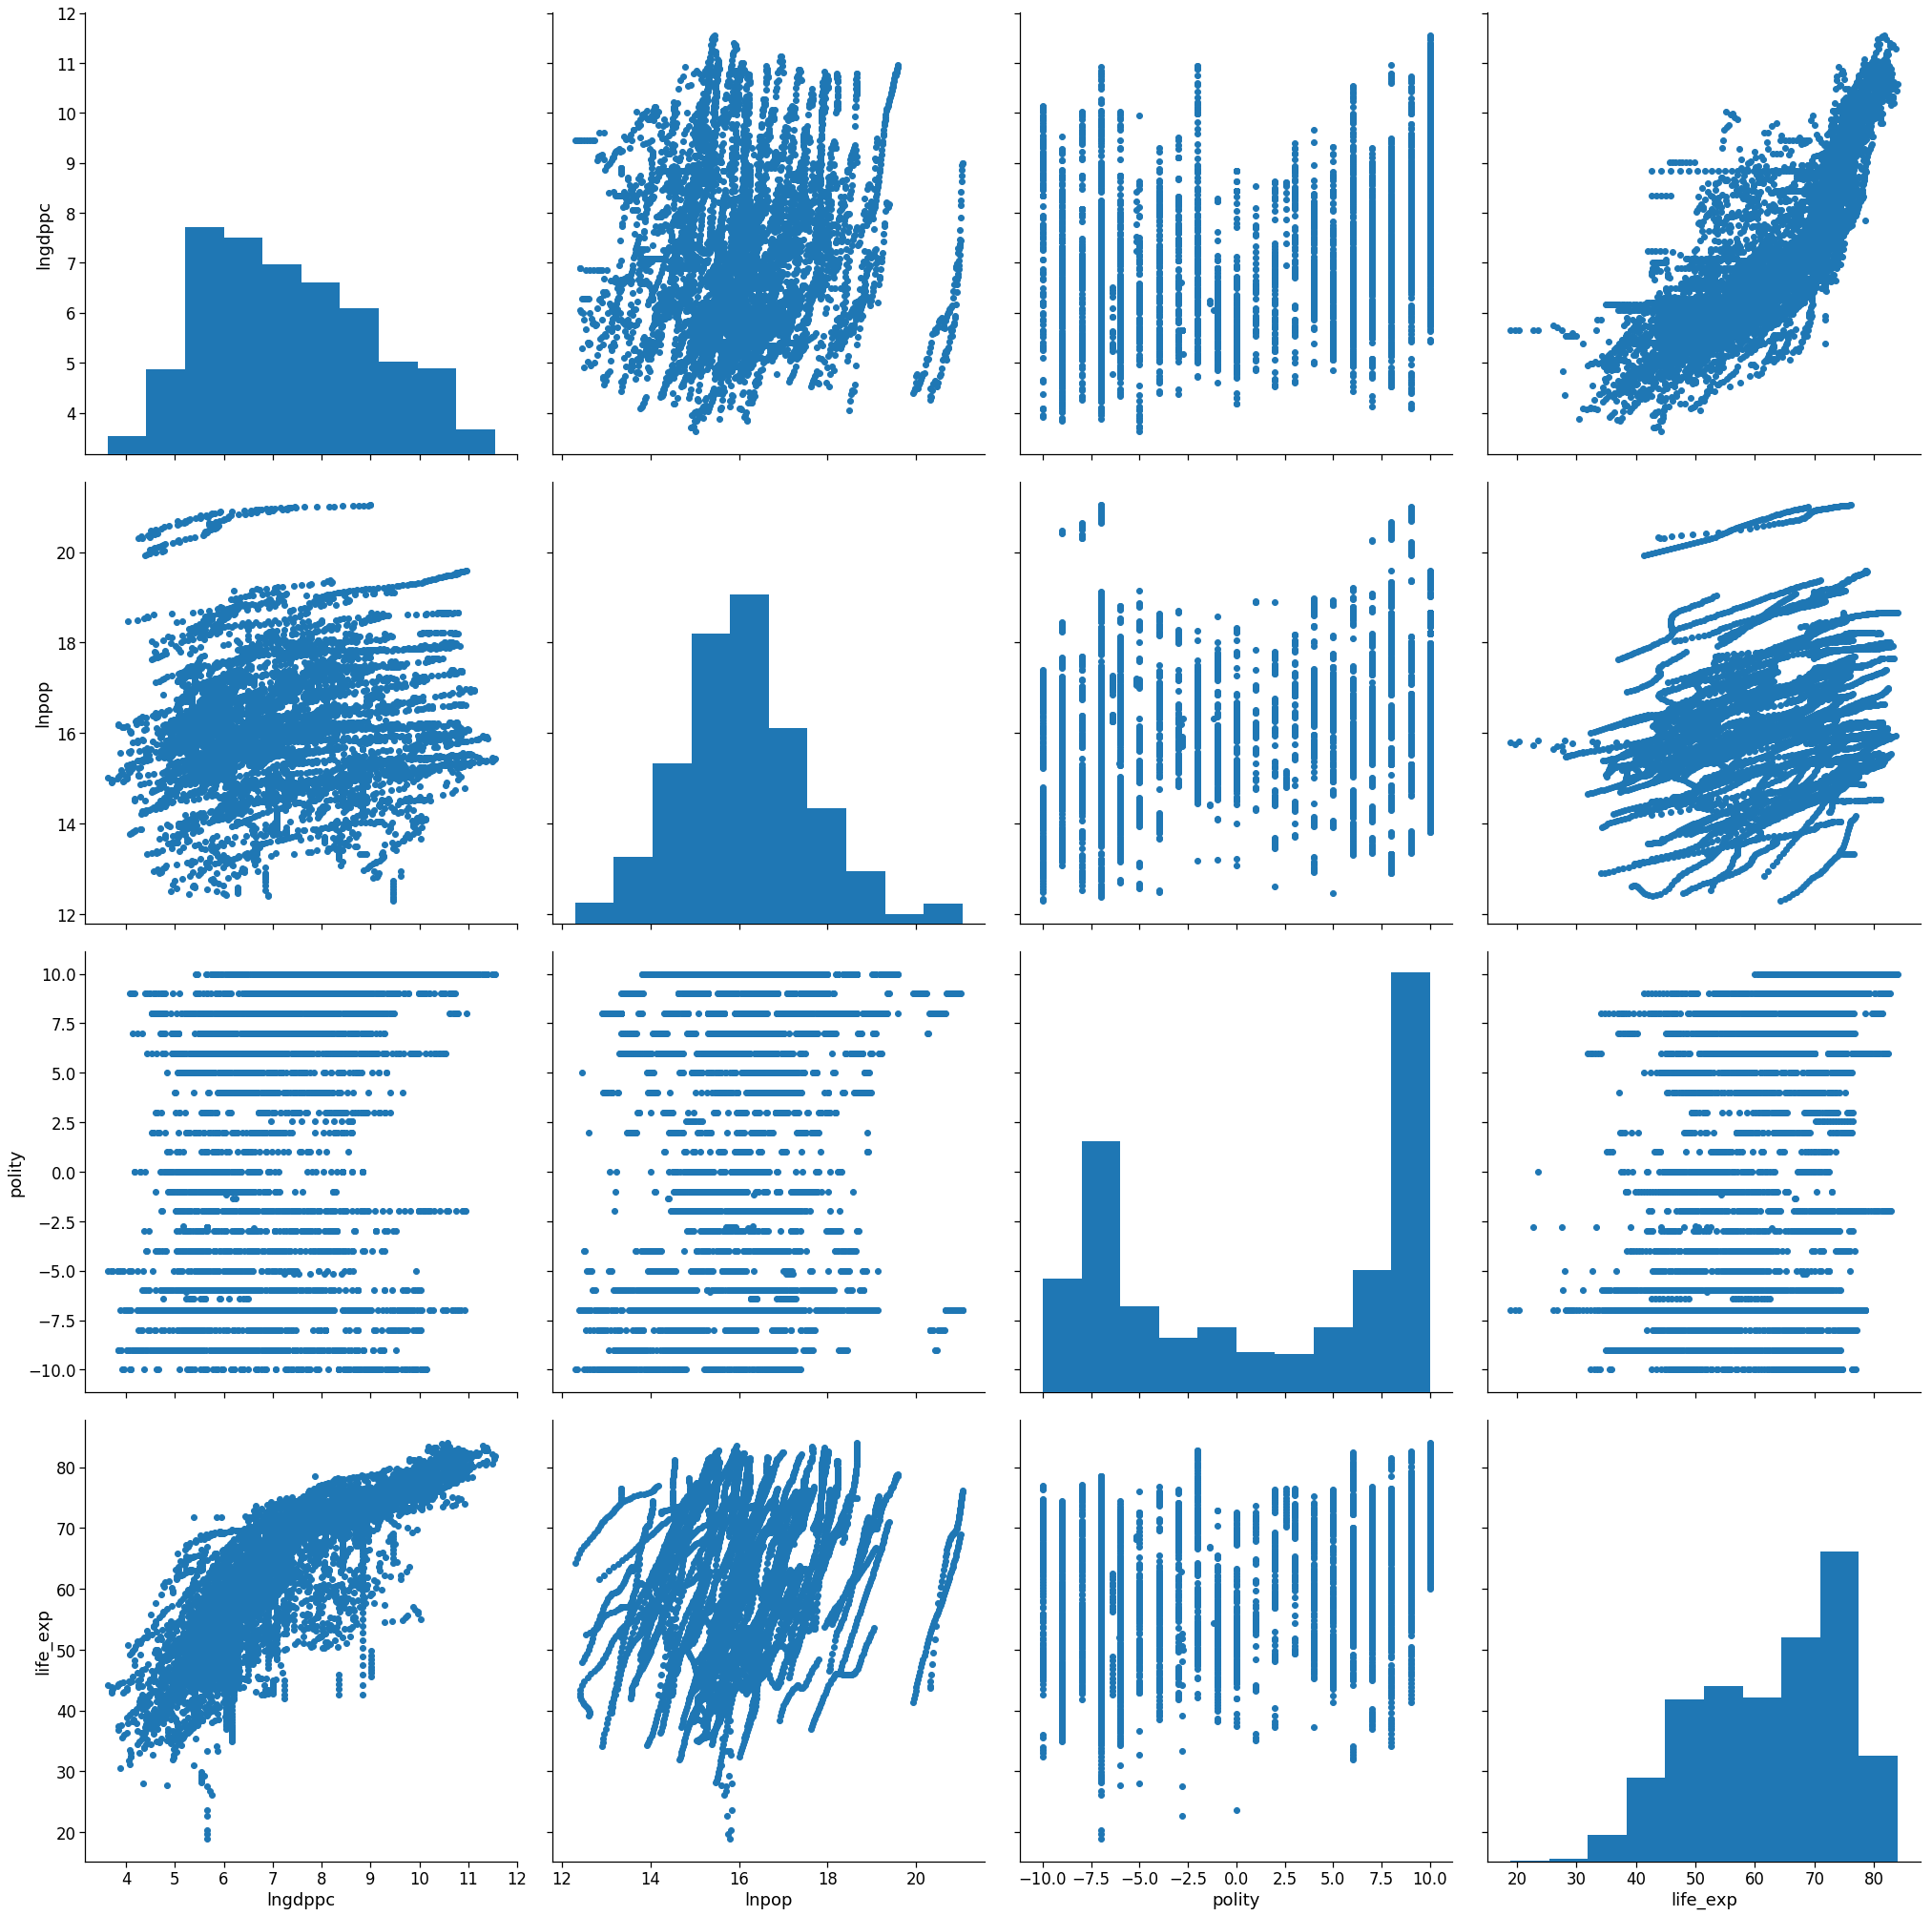

In [351]:
d = dat[['lngdppc','lnpop','polity',"life_exp"]].dropna()

g = sns.PairGrid(d,height=7)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

### Categorical (Discrete) Variables 

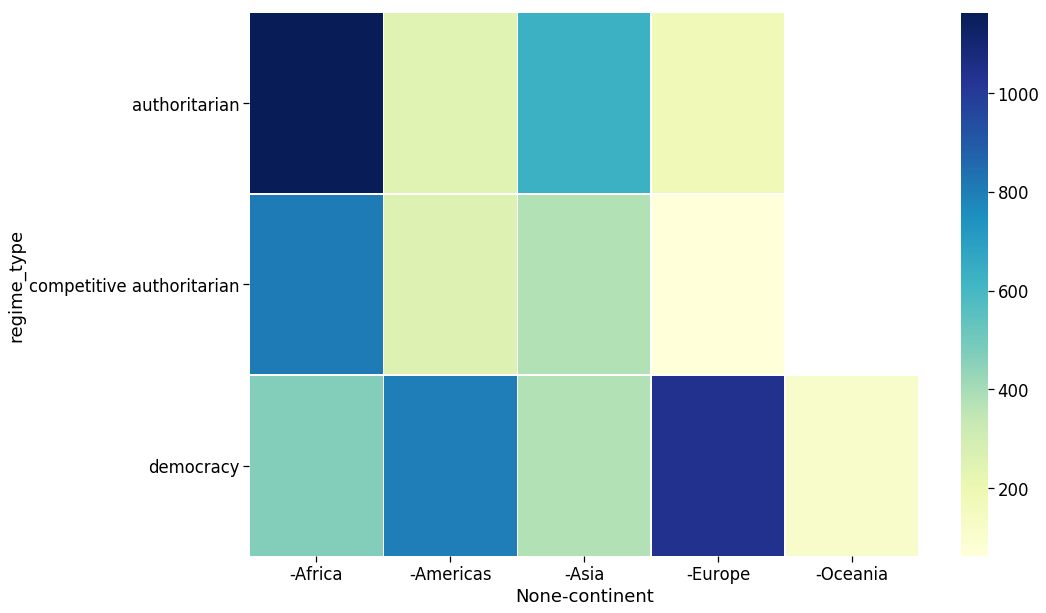

In [336]:
d = dat.groupby(['continent','regime_type']).size().reset_index().rename(columns={0:''})
d = d.pivot_table(columns="continent",index='regime_type')

plt.figure(figsize=(15,10))
sns.heatmap(d,linewidths=.5,cmap="YlGnBu")

### Categorical (Discrete) Variables + Continuous Variables

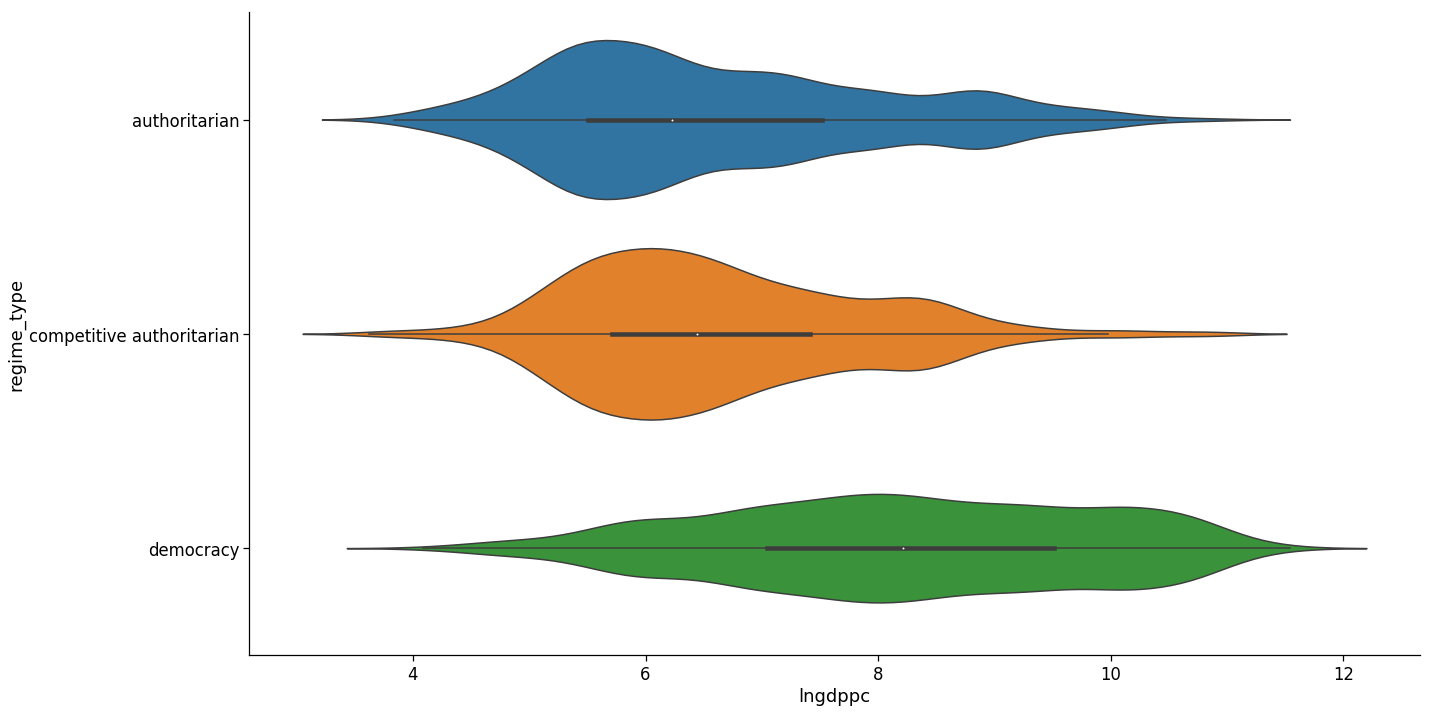

In [321]:
g = sns.catplot(y="regime_type", x="lngdppc",
                kind="violin",
                height=10,aspect=2,
                data=dat)

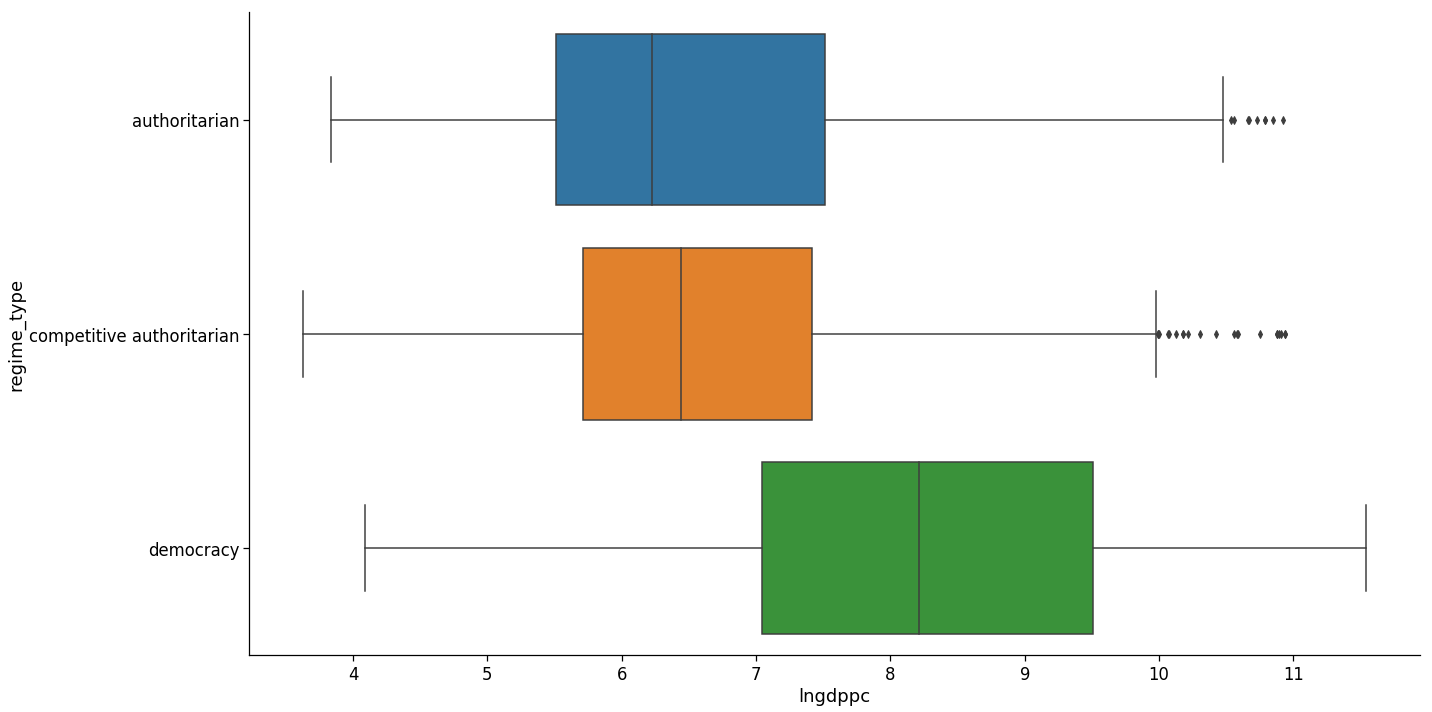

In [320]:
g = sns.catplot(y="regime_type", x="lngdppc", 
                kind="box",
                height=10,aspect=2,
                data=dat)

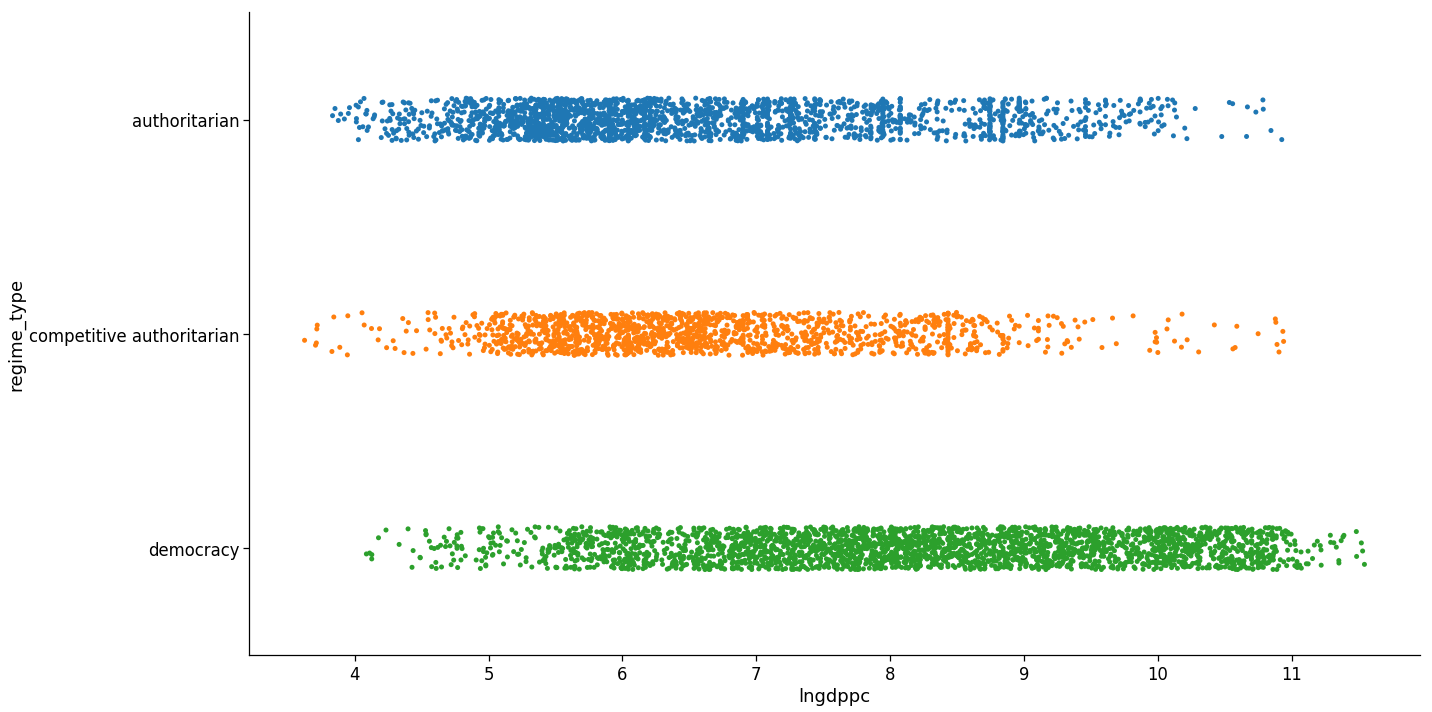

In [322]:
g = sns.catplot(y="regime_type", x="lngdppc", 
                height=10,aspect=2,
                data=dat)

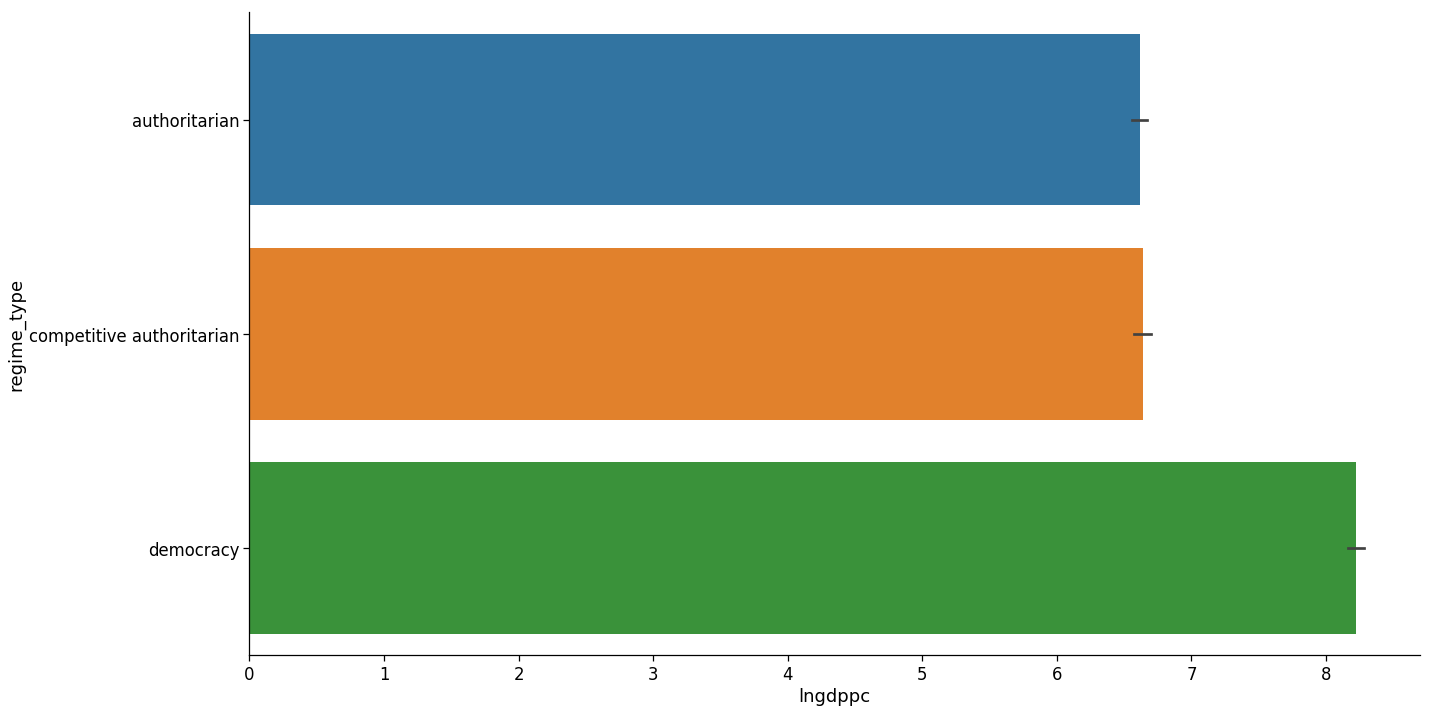

In [323]:
g = sns.catplot(y="regime_type", x="lngdppc",
                kind="bar",
                height=10,aspect=2,
                data=dat)